### **Overview**

**Question Prompt** - Our goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

**Dataset** - Vehicles dataset containing information on 426K car sales data.



In [1]:
# Imports

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sys
!{sys.executable} -m pip install fuzzywuzzy

from fuzzywuzzy import fuzz, process
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance


In [2]:
# Load and perform EDA (Exploratory Data Analysis)

data = pd.read_csv('data/vehicles.csv')
# understand the data 
# data
# data.describe()
data.info()
print(f'Statging dataframe shape {data.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Null values
id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64
Unique values per column
id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64
price
0        32895
6995      3169
7995      3129
9995      2867
8995      2837
         ...  
7530         

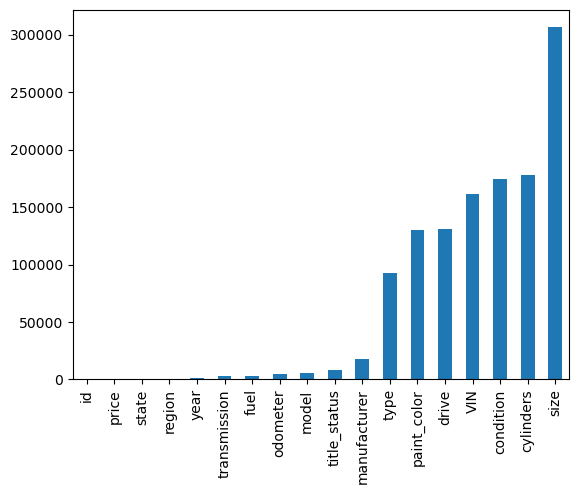

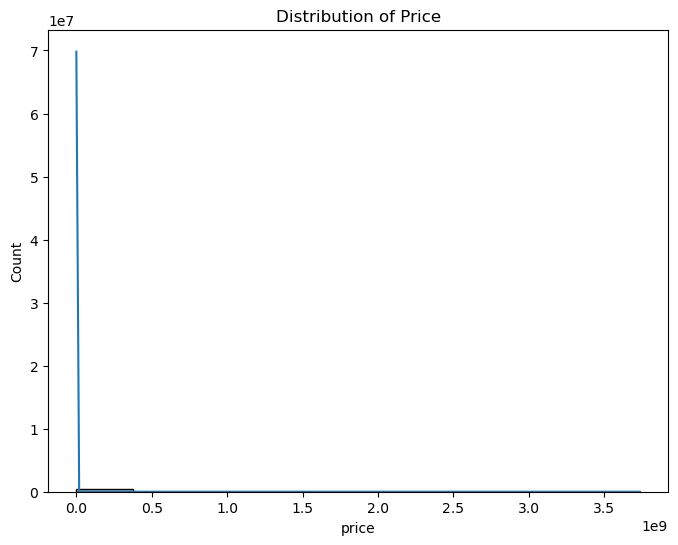

In [3]:
# Explore null or missing values
print('Null values')
print(data.isnull().sum())
data.isnull().sum().sort_values().plot(kind = 'bar')

# Check the number of unique values of each column
print('Unique values per column')
print(data.nunique())

# Explore price column
print(data[['price']].value_counts())

# Visual exploration for our target Price
plt.figure(figsize=(8, 6))
sns.histplot(data=data['price'], bins=10, kde=True)
plt.title('Distribution of Price')
plt.show()

## **Data Observations**
1. We have a lot of categorical columns v/s numerical columns
2. Size, cylinders, condition and VIN columns are most empty. And need to be further inspected
3. VIN numbers are unique for cars and if there are null or duplicated VIN values we should probably fix and drop those rows
4. Size column can be dropped given the large missing data set.
5. Price distribution count plot has a very large skew towards the left and large spread and needs further exploration


In [5]:
# Clean up the data
print(f'Starting dataframe shape {data.shape}')

# drop size column
data_filtered = data.drop('size', axis='columns')
print(f'Dropped size column: {data_filtered.shape}')

# Clean up VIN column : Drop duplicate VIN rows, but keep the rows with empty VIN value by populating it with the ID value
data_filtered['VIN'] = data_filtered['VIN'].astype("string")
data_filtered['VIN'] = data_filtered['VIN'].fillna(data_filtered['id'].astype(str))

data_filtered_for_vin = data_filtered.drop_duplicates(subset=['VIN'])
print(f'Dropped duplicate VIN numbers : {data_filtered_for_vin.shape}')

# drop null values in models 
data_filtered_for_vin.dropna(subset = ['model'], inplace=True)
print(f'Dropped null model values : {data_filtered_for_vin.shape}')

# Fix blank Manufacture row entries by splitting the Model row entry
data_filtered_for_vin['manufacturer'] = data_filtered_for_vin['manufacturer'].astype("string")
data_filtered_for_vin['model'] = data_filtered_for_vin['model'].astype("string")

manufacture_vals_from_model_split = data_filtered_for_vin['model'].str.split(' ').apply(lambda x: x[0])
data_filtered_for_vin['manufacturer'] = data_filtered_for_vin['manufacturer'].fillna(manufacture_vals_from_model_split)

# Clean rows where model value is a 0, 1, #NAME?, -3500, -2500 
data_filtered_for_vin.query('model != "0" | model != "1" | model != "#NAME?" | model != "-3500" | model != "-2500"', inplace=True)

# Clean up rows where region(?), price, year, manufacturer, model, condition, cylinder, fuel, odometer are duplicates
columns = ['price', 'year', 'manufacturer', 'model', 'odometer']
data_filtered_for_vin.drop_duplicates(subset=columns, inplace=True)

print(f'Clean up rows where price, year, manufacturer, model and odometer values are duplicates : {data_filtered_for_vin.shape}')
# print("$$$$$$$$$$$$$$$$$$$$$$$$$")

# Fix manufacturer names Lambo Lamborghini lamborghini lamborghini LAMBORGHINI and mclaren MCLAREN Mclaren
# df['A'].replace({'foo': 'qux', 'bar': 'quux'}, inplace=True)
data_filtered_for_vin['manufacturer'].replace({'Lambo': 'Lamborghini', 'lamborghini': 'Lamborghini', 'LAMBORGHINI': 'Lamborghini'}, inplace=True)
data_filtered_for_vin['manufacturer'].replace({'mclaren': 'McLaren', 'MCLAREN': 'McLaren', 'Mclaren': 'McLaren'}, inplace=True)


# Filter out extreme price values
data_filtered_for_price = data_filtered_for_vin.query('price > 0 & price < 1000000')
print(f'Filtered price not zero and less than million : {data_filtered_for_price.shape}')

# Export to CSV to visually inspect data cleaning 
# data_filtered_for_price.to_csv('data/vehicles_clean_1.csv')

print(data_filtered_for_price.info())

Starting dataframe shape (426880, 18)
Dropped size column: (426880, 17)
Dropped duplicate VIN numbers : (279288, 17)
Dropped null model values : (274949, 17)
Clean up rows where price, year, manufacturer, model and odometer values are duplicates : (234384, 17)
$$$$$$$$$$$$$$$$$$$$$$$$$
Filtered price not zero and less than million : (218492, 17)


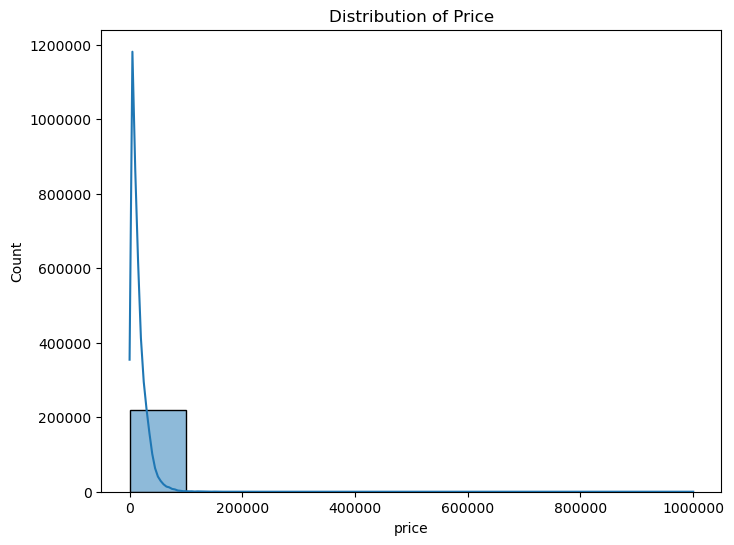

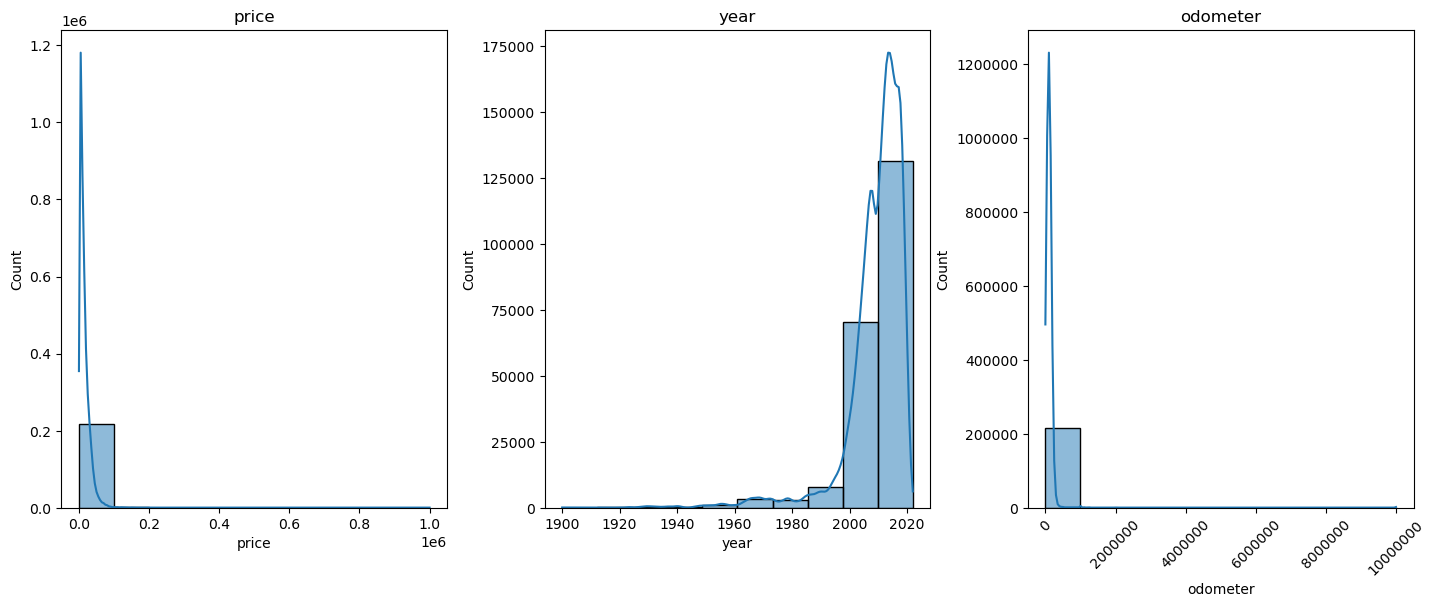

In [7]:
# Visual exploration for our Price
plt.figure(figsize=(8, 6))
sns.histplot(data=data_filtered_for_price['price'], bins=10, kde=True)
plt.title('Distribution of Price')
plt.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()


# Distribution of Numerical Features
numerical_features = ['price', 'year', 'odometer']

plt.figure(figsize=(24, 16))
for feature in numerical_features:
    plt.subplot(3, 5, numerical_features.index(feature) + 1)
    sns.histplot(data=data_filtered_for_price[feature], bins=10, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.tick_params("x", rotation=45)
plt.show()

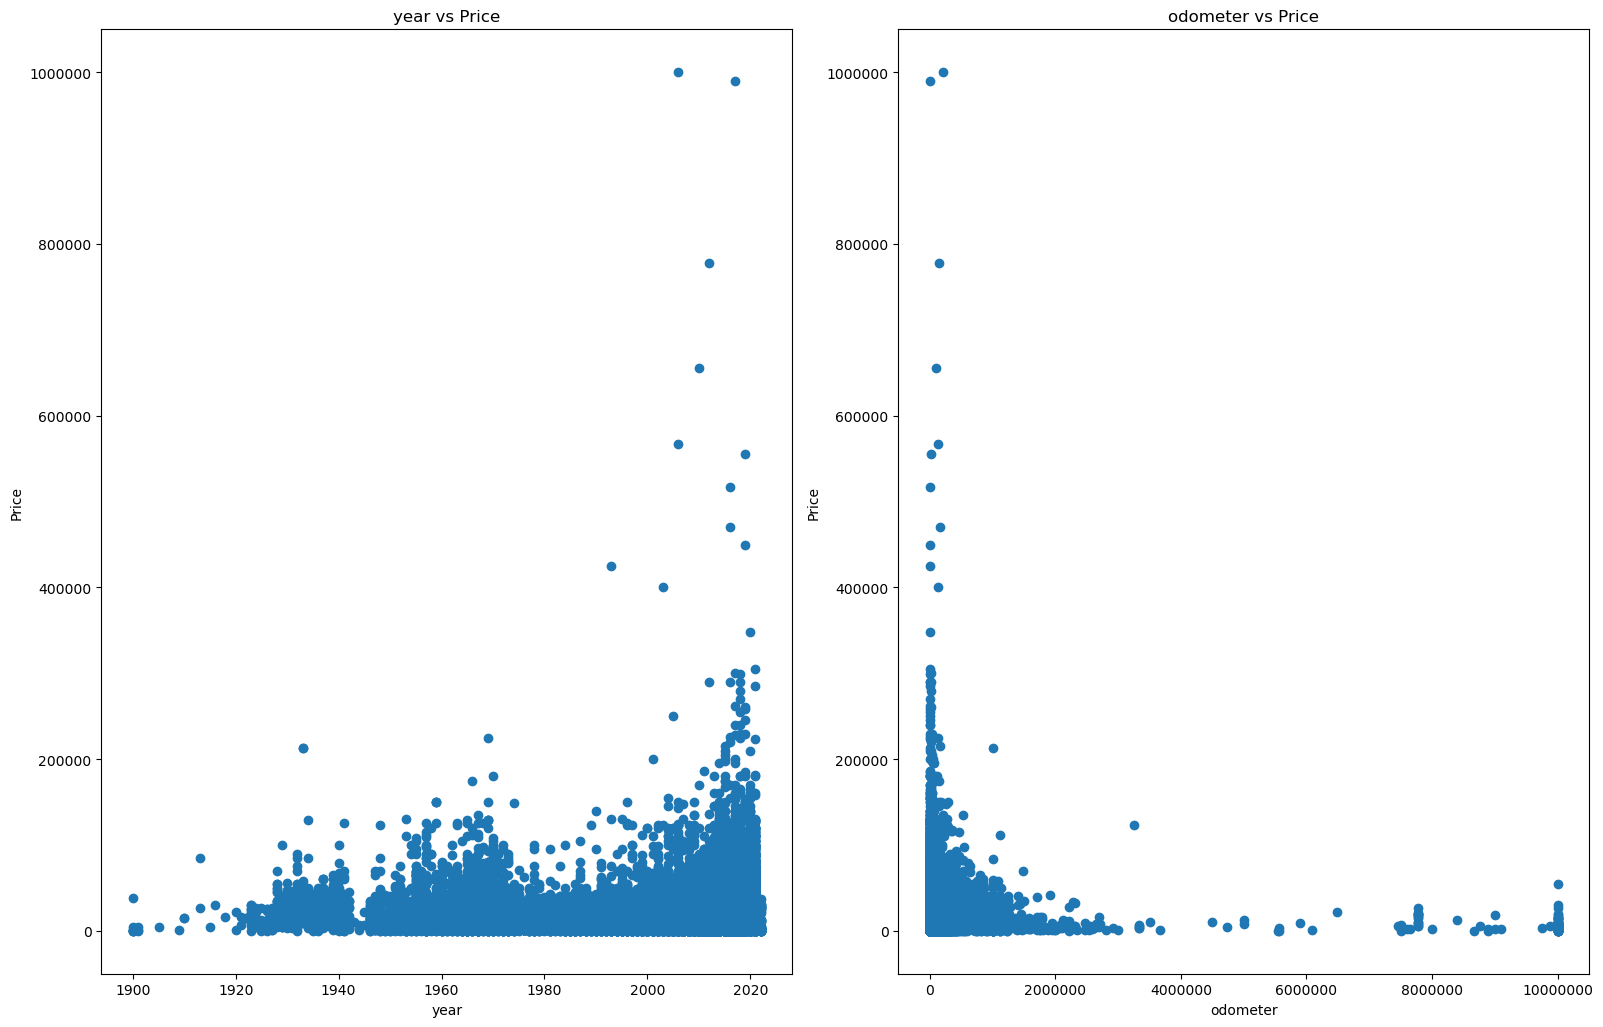

In [8]:
# Scatterplots for numerical features v/s Price
numerical_features_without_price = ['year', 'odometer']

plt.figure(figsize=(40,30))
for feature in numerical_features_without_price:
    plt.subplot(3, 5, numerical_features_without_price.index(feature) + 1)
    plt.scatter(data_filtered_for_price[feature], data_filtered_for_price['price'])
    plt.title(feature+' vs Price')
    plt.ylabel('Price')
    plt.xlabel(feature)
    plt.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.tight_layout()

#### **Numerical Data Inference**
1. Year feature shows a strong positive correlation with Price of the vehicle
2. Odometer feature shows a negative correalation with the Price of the vehicle

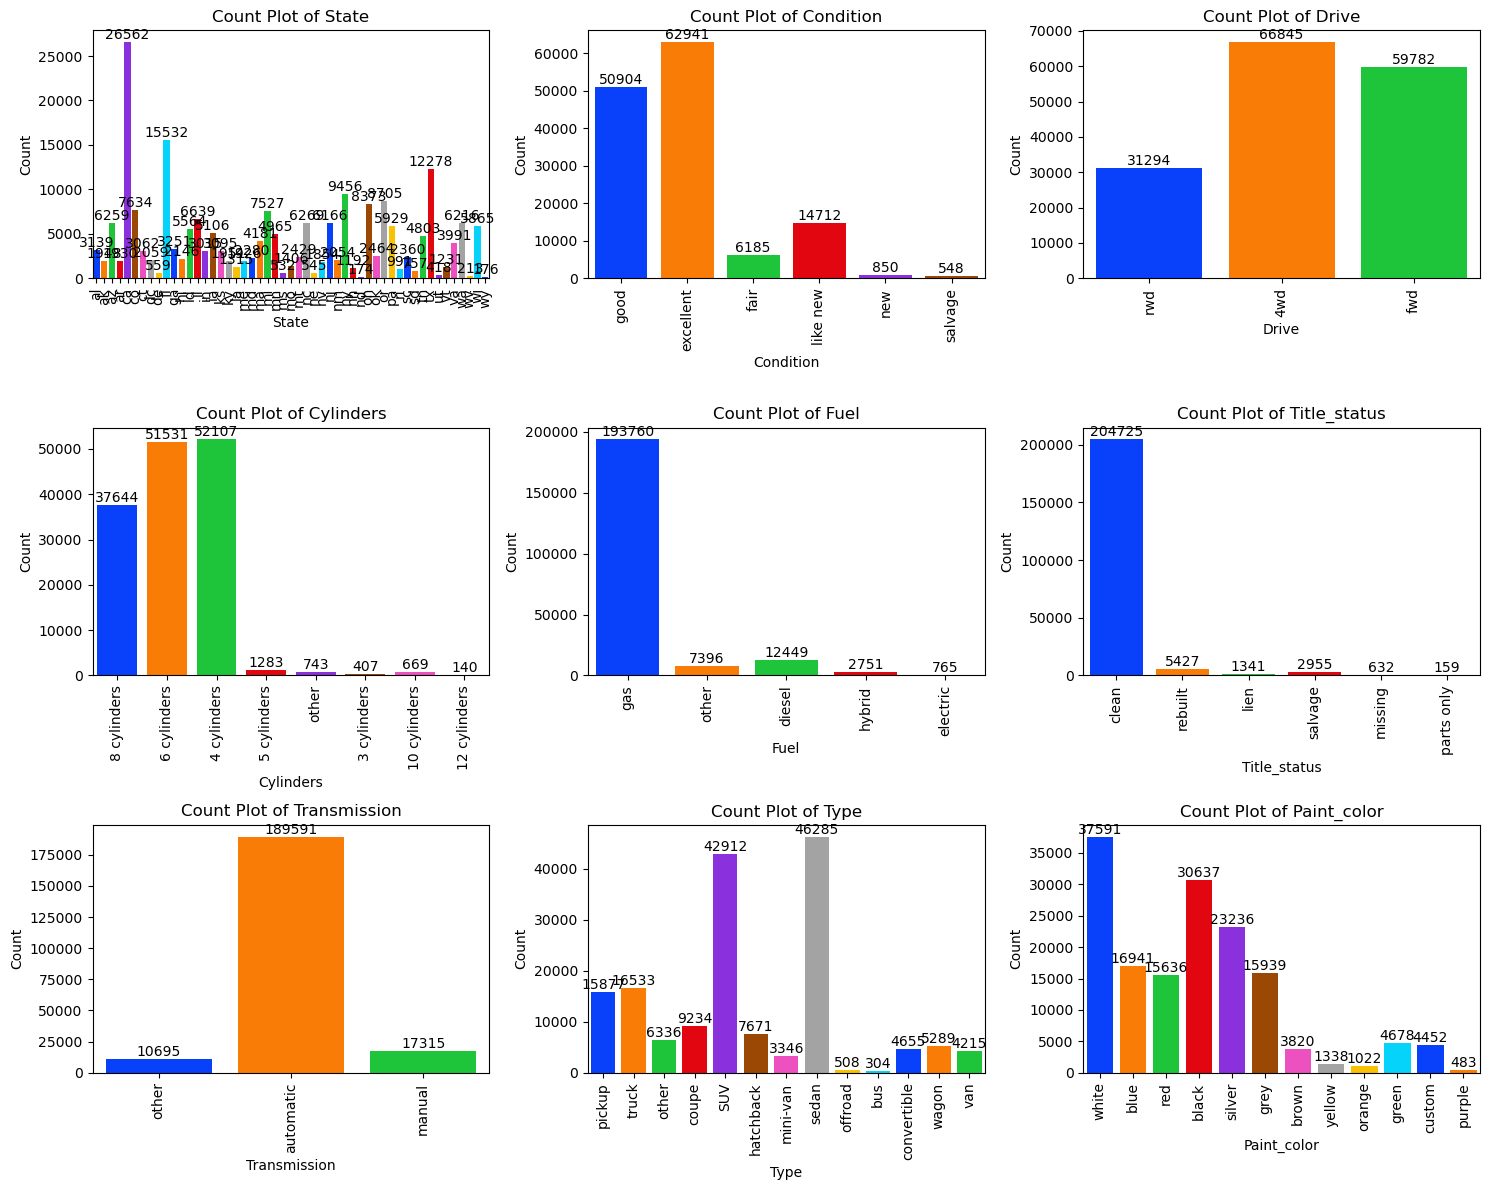

In [10]:
# Distribution of Categorical Features

# List of categorical columns to analyze
categorical_columns = ['state', 'condition', 'drive',
                       'cylinders', 'fuel', 'title_status',
                      'transmission', 'type', 'paint_color']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.ravel()  

# Loop through each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(x=data_filtered_for_price[column], data=data_filtered_for_price, palette='bright', ax=axes[i], saturation=0.95)
    for container in axes[i].containers:
        axes[i].bar_label(container, color='black', size=10)
    axes[i].set_title(f'Count Plot of {column.capitalize()}')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Count')
    axes[i].tick_params("x", rotation=90)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

id                  0
region              0
price               0
year              580
manufacturer        0
model               0
condition       82352
cylinders       73968
fuel             1371
odometer         1156
title_status     3253
transmission      891
VIN                 0
drive           60571
type            55327
paint_color     62719
state               0
dtype: int64


<Axes: >

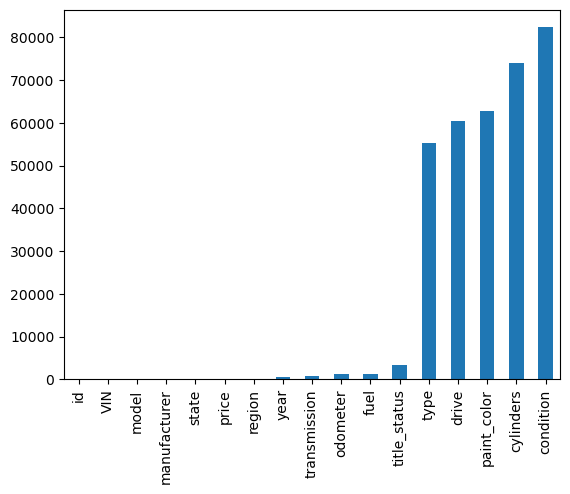

In [11]:
# #### **Categorical Data Inference**
# 1. Year feature shows a strong positive correlation with Price of the vehicle
# 2. Odometer feature shows a negative correalation with the Price of the vehicle

print(data_filtered_for_price.isnull().sum())
data_filtered_for_price.isnull().sum().sort_values().plot(kind = 'bar')


Unique values for manufacturer : 2220


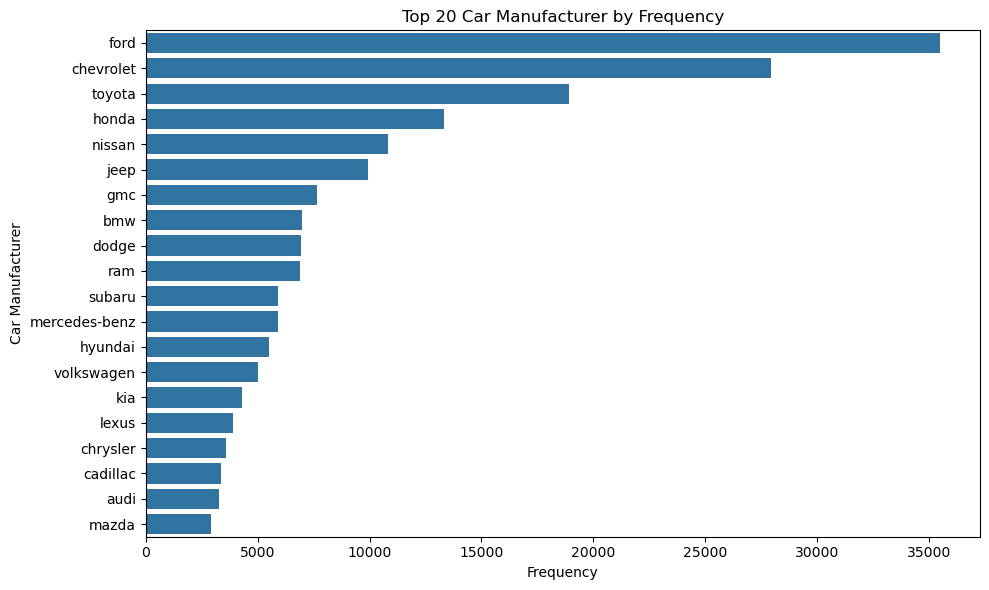

In [12]:
# Check for uniques for manufacturer column and try to reduce it down for Categorical column encoding
print(f'Unique values for manufacturer : {data_filtered_for_price['manufacturer'].nunique()}')

n = 20  # Number of top car models to plot
top_car_models = data_filtered_for_price['manufacturer'].value_counts().head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Manufacturer by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Car Manufacturer')
plt.tight_layout()
plt.show()

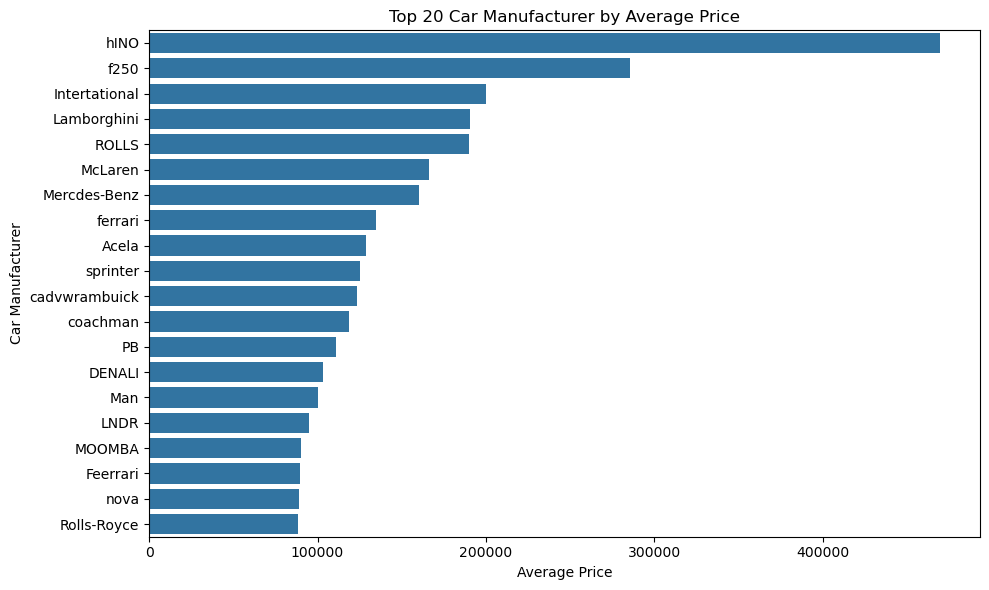

In [13]:
# Calculate average price for each car model
avg_prices_by_car = data_filtered_for_price.groupby('manufacturer')['price'].mean().sort_values(ascending=False)

# Plot top N car models by average price
n = 20  # Number of top car models to plot
top_car_models = avg_prices_by_car.head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Manufacturer by Average Price')
plt.xlabel('Average Price')
plt.ylabel('Car Manufacturer')
plt.tight_layout()
plt.show()

In [14]:
# Clean up Manufacturer column for duplicates and singular entries

def replace_values_with_fuzzy_matching(df, column_name, threshold=80):
 # Replaces values in a DataFrame column based on fuzzy string matching.

 #        Args:
 #            df (pd.DataFrame): The input DataFrame.
 #            column_name (str): The name of the column to clean.
 #            threshold (int): The minimum matching score (0-100) to consider a match.

 #        Returns:
 #            pd.DataFrame: The DataFrame with cleaned column values.
    unique_values = df[column_name].unique()
    for i, value in enumerate(unique_values):
        matches = process.extract(value, unique_values[i+1:], scorer=fuzz.token_sort_ratio)
        for match, score in matches:
            if score >= threshold:
                df[column_name] = df[column_name].replace(match, value)
    return df

df1 = data_filtered_for_price[data_filtered_for_price['manufacturer'].str.isnumeric() == False]

# Clean the 'Manufacturer' column
df2 = replace_values_with_fuzzy_matching(df1, 'manufacturer')

print(f'df2 : {df2.shape}')

# Identify values with counts less than a threshold (e.g., 2)
threshold = 2
value_counts = df2['manufacturer'].value_counts()
values_to_remove = value_counts[value_counts < threshold].index

# Remove rows containing those values
df3 = df2[~df2['manufacturer'].isin(values_to_remove)]

print(f'df3 : {df3.shape}')

# Remove manufacturer values which start with -, % and # 
data_filtered_for_manufacturer = df3[~df3.manufacturer.str.startswith(('-', '%', '#'))]

# Check for uniques for manufacturer column
print(f'Unique values for manufacturer : {data_filtered_for_manufacturer['manufacturer'].nunique()}')



df2 : (216941, 17)
df3 : (216278, 17)
Unique values for manufacturer : 564


In [21]:
print(f' After fixing condition values + {data_filtered_for_manufacturer[['manufacturer']].value_counts()}')

 After fixing condition values + manufacturer  
ford              35519
chevrolet         27972
toyota            18906
honda             13354
nissan            10844
                  ...  
1973VOLKSWAGEN        2
Oshkosh               2
P30                   2
PALOMINO              2
Nisaan                2
Name: count, Length: 564, dtype: int64


id                  0
region              0
price               0
year              526
manufacturer        0
model               0
condition       81830
cylinders       73228
fuel             1361
odometer         1151
title_status     3244
transmission      886
VIN                 0
drive           59700
type            54452
paint_color     61978
state               0
dtype: int64
Shape of data_filtered_for_manufacturer : (216240, 17)
 After fixing condition values + manufacturer  
ford              35519
chevrolet         27972
toyota            18906
honda             13354
nissan            10844
                  ...  
1973VOLKSWAGEN        2
Oshkosh               2
P30                   2
PALOMINO              2
Nisaan                2
Name: count, Length: 564, dtype: int64


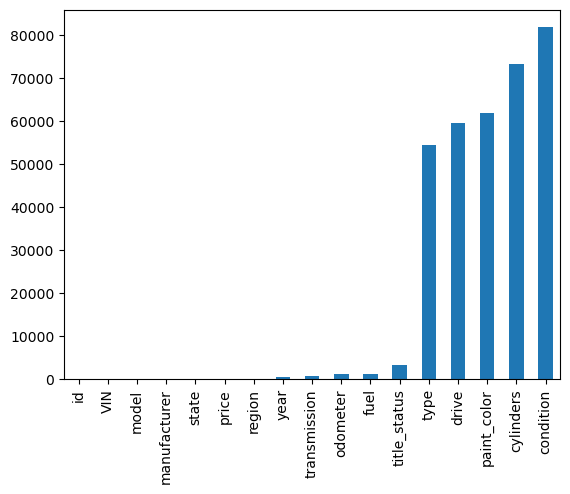

In [23]:
# Check for null values to see if we need to drop or fill (impute/compute)
print(data_filtered_for_manufacturer.isnull().sum())
data_filtered_for_manufacturer.isnull().sum().sort_values().plot(kind = 'bar')
print(f'Shape of data_filtered_for_manufacturer : {data_filtered_for_manufacturer.shape}')
print(f' After fixing condition values + {data_filtered_for_manufacturer[['manufacturer']].value_counts()}')

In [24]:
# Let impute values for cylinders
print(data_filtered_for_manufacturer[['cylinders']].value_counts())

# we will change null values for cylinders with "other"
data_filtered_for_manufacturer['cylinders'].fillna('other', inplace=True)

print(f' After fixing cylinder values + {data_filtered_for_manufacturer[['cylinders']].value_counts()}')
print(f'Shape of data_filtered_for_manufacturer : {data_filtered_for_manufacturer.shape}')

# Let impute values for condition
print(data_filtered_for_manufacturer[['condition']].value_counts())

# we will change the condition values to fair if the title value is clean
data_filtered_for_manufacturer.loc[data_filtered_for_manufacturer['title_status'] == 'clean', 'condition'] = 'fair'

# We will change null values for drive, type and paint_color with "other"
data_filtered_for_manufacturer['condition'].fillna('unknown', inplace=True)

print(f' After fixing condition values + {data_filtered_for_manufacturer[['condition']].value_counts()}')
print(f'Shape of data_filtered_for_manufacturer : {data_filtered_for_manufacturer.shape}')

cylinders   
4 cylinders     51723
6 cylinders     51120
8 cylinders     37021
5 cylinders      1263
other             696
10 cylinders      656
3 cylinders       394
12 cylinders      139
Name: count, dtype: int64
 After fixing cylinder values + cylinders   
other           73924
4 cylinders     51723
6 cylinders     51120
8 cylinders     37021
5 cylinders      1263
10 cylinders      656
3 cylinders       394
12 cylinders      139
Name: count, dtype: int64
Shape of data_filtered_for_manufacturer : (216240, 17)
condition
excellent    62265
good         50260
like new     14499
fair          6032
new            816
salvage        538
Name: count, dtype: int64
 After fixing condition values + condition
fair         203174
excellent      5611
unknown        3483
good           2477
like new       1096
salvage         330
new              69
Name: count, dtype: int64
Shape of data_filtered_for_manufacturer : (216240, 17)


In [25]:
# Check for null values to see if we need to drop or fill (impute/compute)
print(data_filtered_for_manufacturer.isnull().sum())
print(f'Shape of data_filtered_for_manufacturer : {data_filtered_for_manufacturer.shape}')

id                  0
region              0
price               0
year              526
manufacturer        0
model               0
condition           0
cylinders           0
fuel             1361
odometer         1151
title_status     3244
transmission      886
VIN                 0
drive           59700
type            54452
paint_color     61978
state               0
dtype: int64
Shape of data_filtered_for_manufacturer : (216240, 17)


In [30]:
# Lets first drop all the rows who have drive, type and paint_color as null the rest we can assign unknown
df_temp = data_filtered_for_manufacturer
data_filtered_for_combined_nulls = df_temp.loc[~((df_temp['drive'].isnull()) & (df_temp['type'].isnull()) & (df_temp['paint_color'].isnull()))] 

# Check for uniques for manufacturer column
# print(f'Shape of data_filtered_for_combined_nulls : {data_filtered_for_combined_nulls.shape}')
# print(f' data_filtered_for_combined_nulls + {data_filtered_for_combined_nulls[['manufacturer']].value_counts()}') 
# print(f'Unique values for manufacturer : {data_filtered_for_combined_nulls['manufacturer'].nunique()}')

# Identify values with counts less than a threshold (e.g., 2)
threshold = 2
value_counts = data_filtered_for_combined_nulls['manufacturer'].value_counts()
values_to_remove = value_counts[value_counts < threshold].index

# Remove rows containing those values
df3 = data_filtered_for_combined_nulls[~data_filtered_for_combined_nulls['manufacturer'].isin(values_to_remove)]
# print(f'df3 : {df3.shape}')
data_filtered_for_combined_nulls = df3
# print(f' data_filtered_for_combined_nulls 2 + {data_filtered_for_combined_nulls[['manufacturer']].value_counts()}') 
# print(f'Unique values for manufacturer 2 : {data_filtered_for_combined_nulls['manufacturer'].nunique()}')

# Check for null values to see if we need to drop or fill (impute/compute)
print(data_filtered_for_combined_nulls.isnull().sum())

# We will change null values for drive, type and paint_color with "other"
data_filtered_for_combined_nulls['drive'].fillna('unknown', inplace=True)

data_filtered_for_combined_nulls['type'].fillna('unknown', inplace=True)

data_filtered_for_combined_nulls['paint_color'].fillna('unknown', inplace=True)

data_filtered_for_combined_nulls['title_status'].fillna('unknown', inplace=True)

 # Check for null values to see if we need to drop or fill (impute/compute)
print('Final output post data cleaning')
print(data_filtered_for_combined_nulls.isnull().sum())

print(f'Shape of data_filtered_for_combined_nulls : {data_filtered_for_combined_nulls.shape}')

id                  0
region              0
price               0
year              523
manufacturer        0
model               0
condition           0
cylinders           0
fuel             1203
odometer         1060
title_status     3087
transmission      760
VIN                 0
drive           30993
type            25752
paint_color     33285
state               0
dtype: int64
Final output post data cleaning
id                 0
region             0
price              0
year             523
manufacturer       0
model              0
condition          0
cylinders          0
fuel            1203
odometer        1060
title_status       0
transmission     760
VIN                0
drive              0
type               0
paint_color        0
state              0
dtype: int64
Shape of data_filtered_for_combined_nulls : (187490, 17)


In [37]:
# Now we drop all remaining rows with null values
data_final = data_filtered_for_combined_nulls.dropna()

# Finally we drop the id column as we will have our index
data_final.drop('id', axis='columns', inplace=True)

print(data_final.isnull().sum())
print(f'Shape of data_final : {data_final.shape}')
print('The Data is now cleaned for feature engineering !!!')

# Export to CSV to visually inspect data cleaning 
# data_final.to_csv('data/vehicles_clean_final.csv')

# print(f' After fixing condition values + {data_final[['manufacturer']].value_counts()}')

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
type            0
paint_color     0
state           0
dtype: int64
Shape of data_final : (184048, 16)
The Data is now cleaned for feature engineering !!!


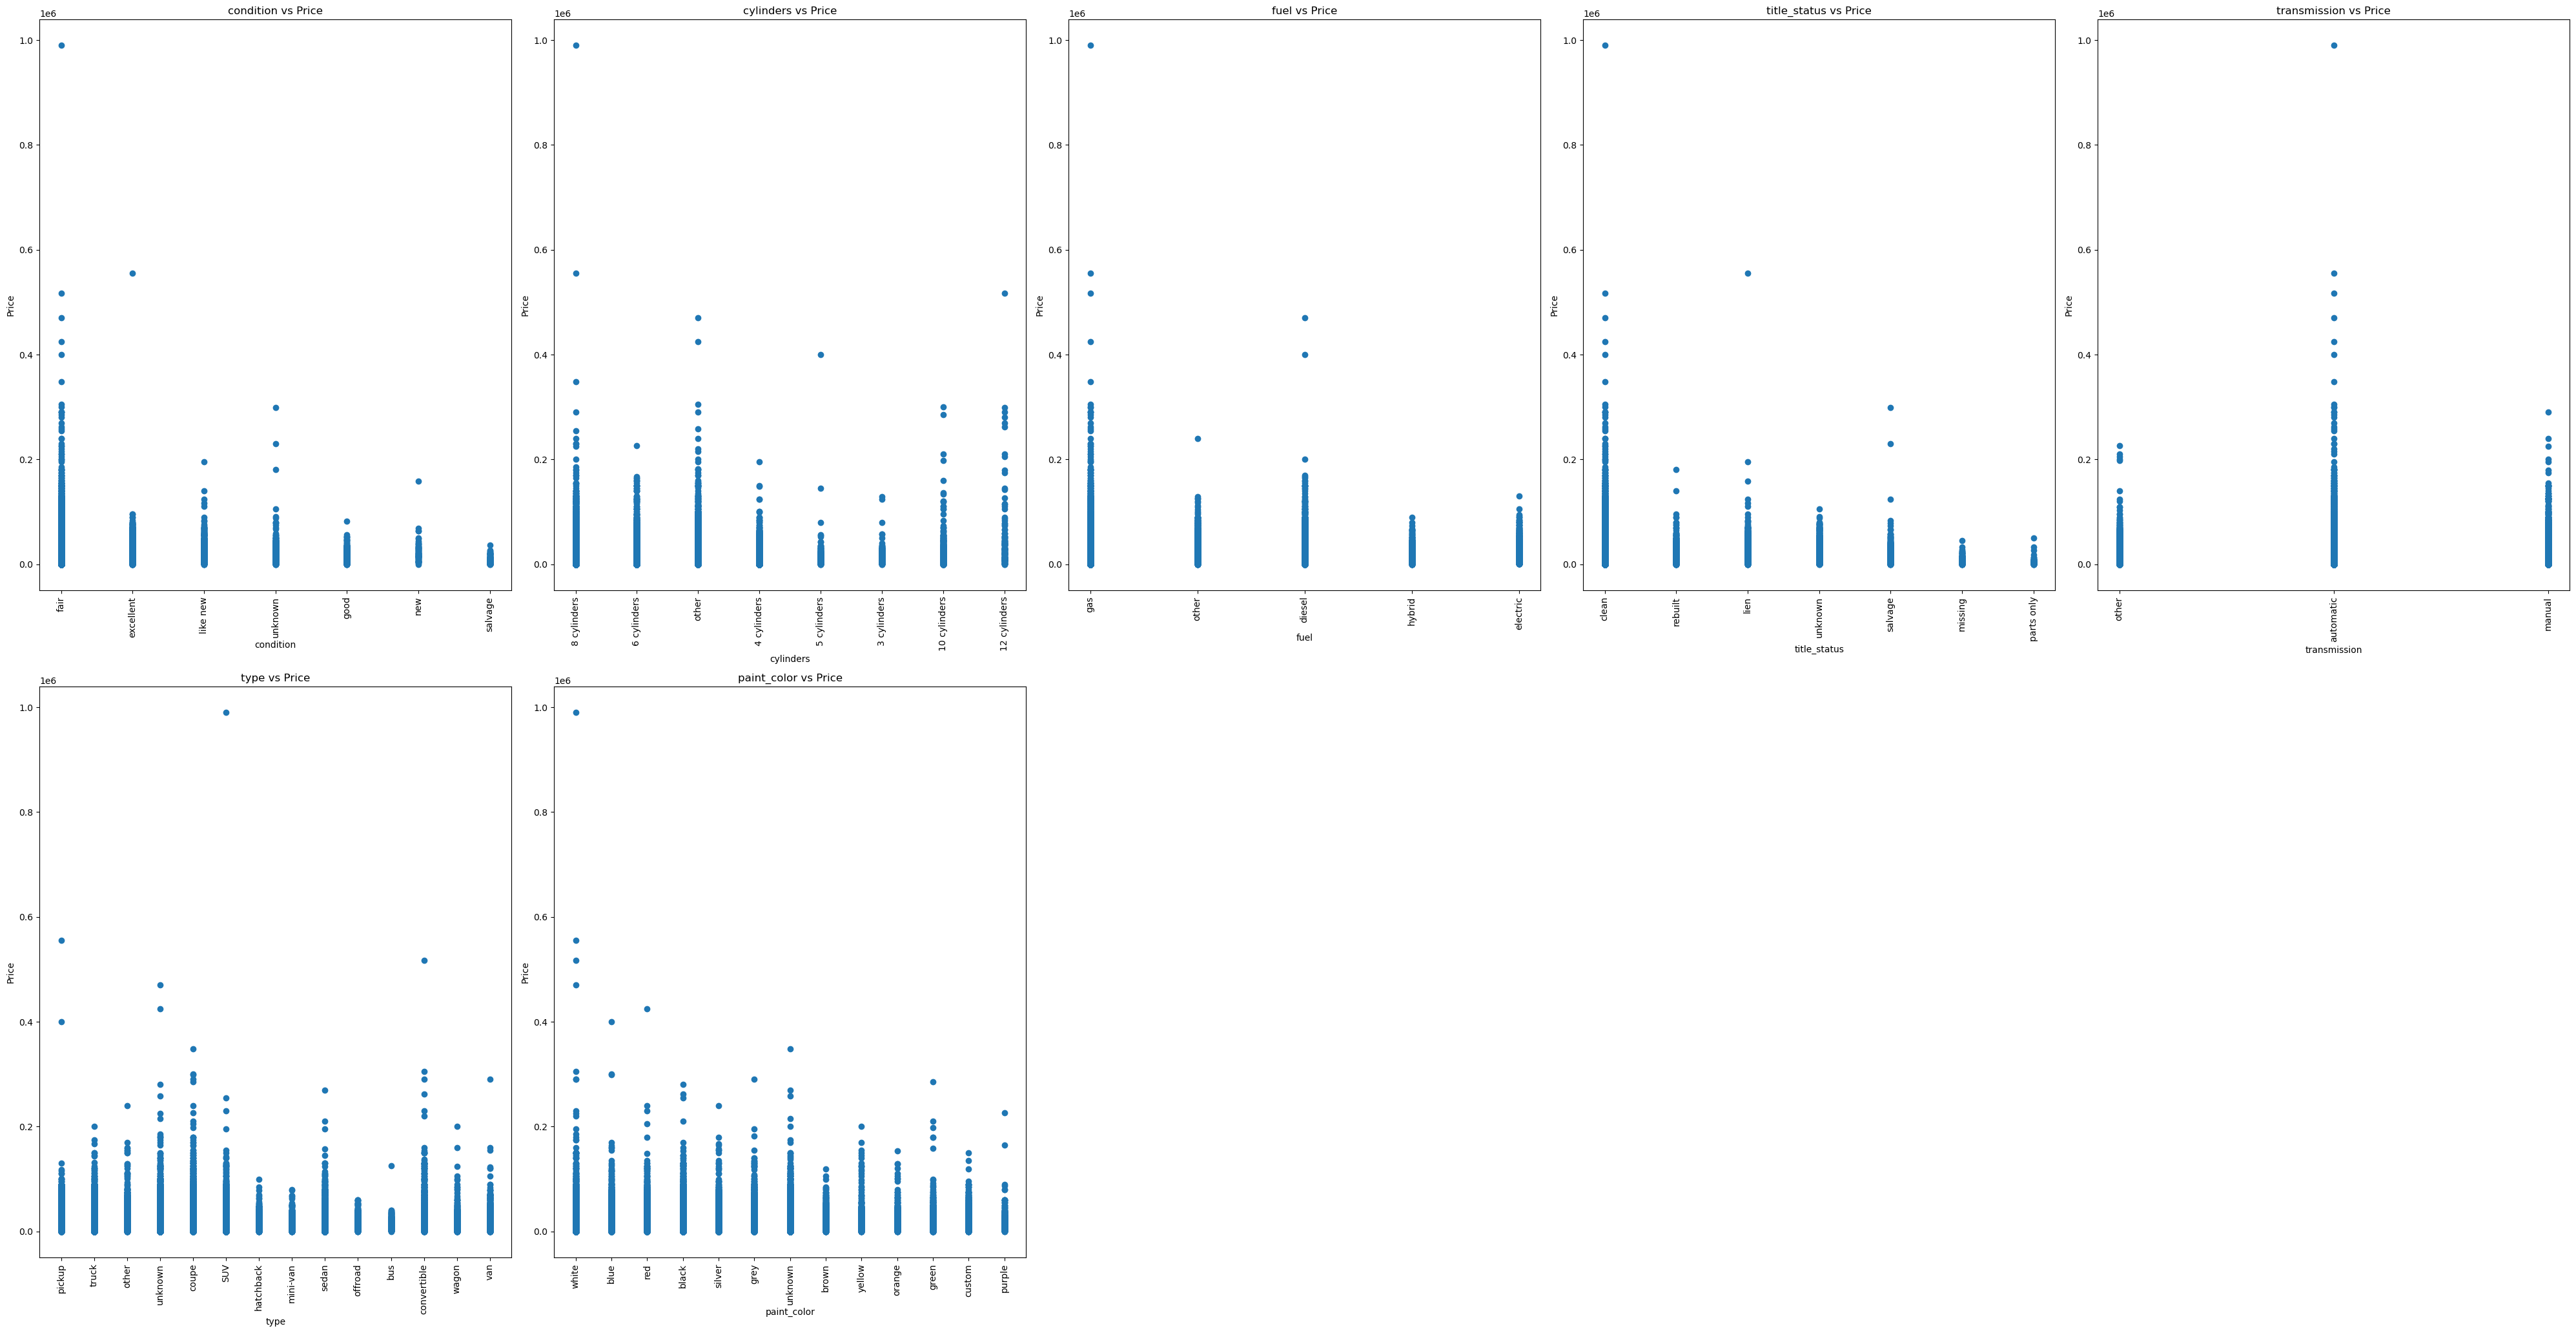

In [39]:
# Visualize ScatterPlots

cat_columns = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'type', 'paint_color']

# Create subplots
plt.figure(figsize=(40,30))
for feature in cat_columns:
    plt.subplot(3, 5, cat_columns.index(feature) + 1)
    plt.scatter(data_final[feature], data_final['price'])
    plt.title(feature+' vs Price')
    plt.ylabel('Price')
    plt.xlabel(feature)
    plt.tick_params("x", rotation=90) 

# Adjust layout and show plots
plt.tight_layout()
plt.show()

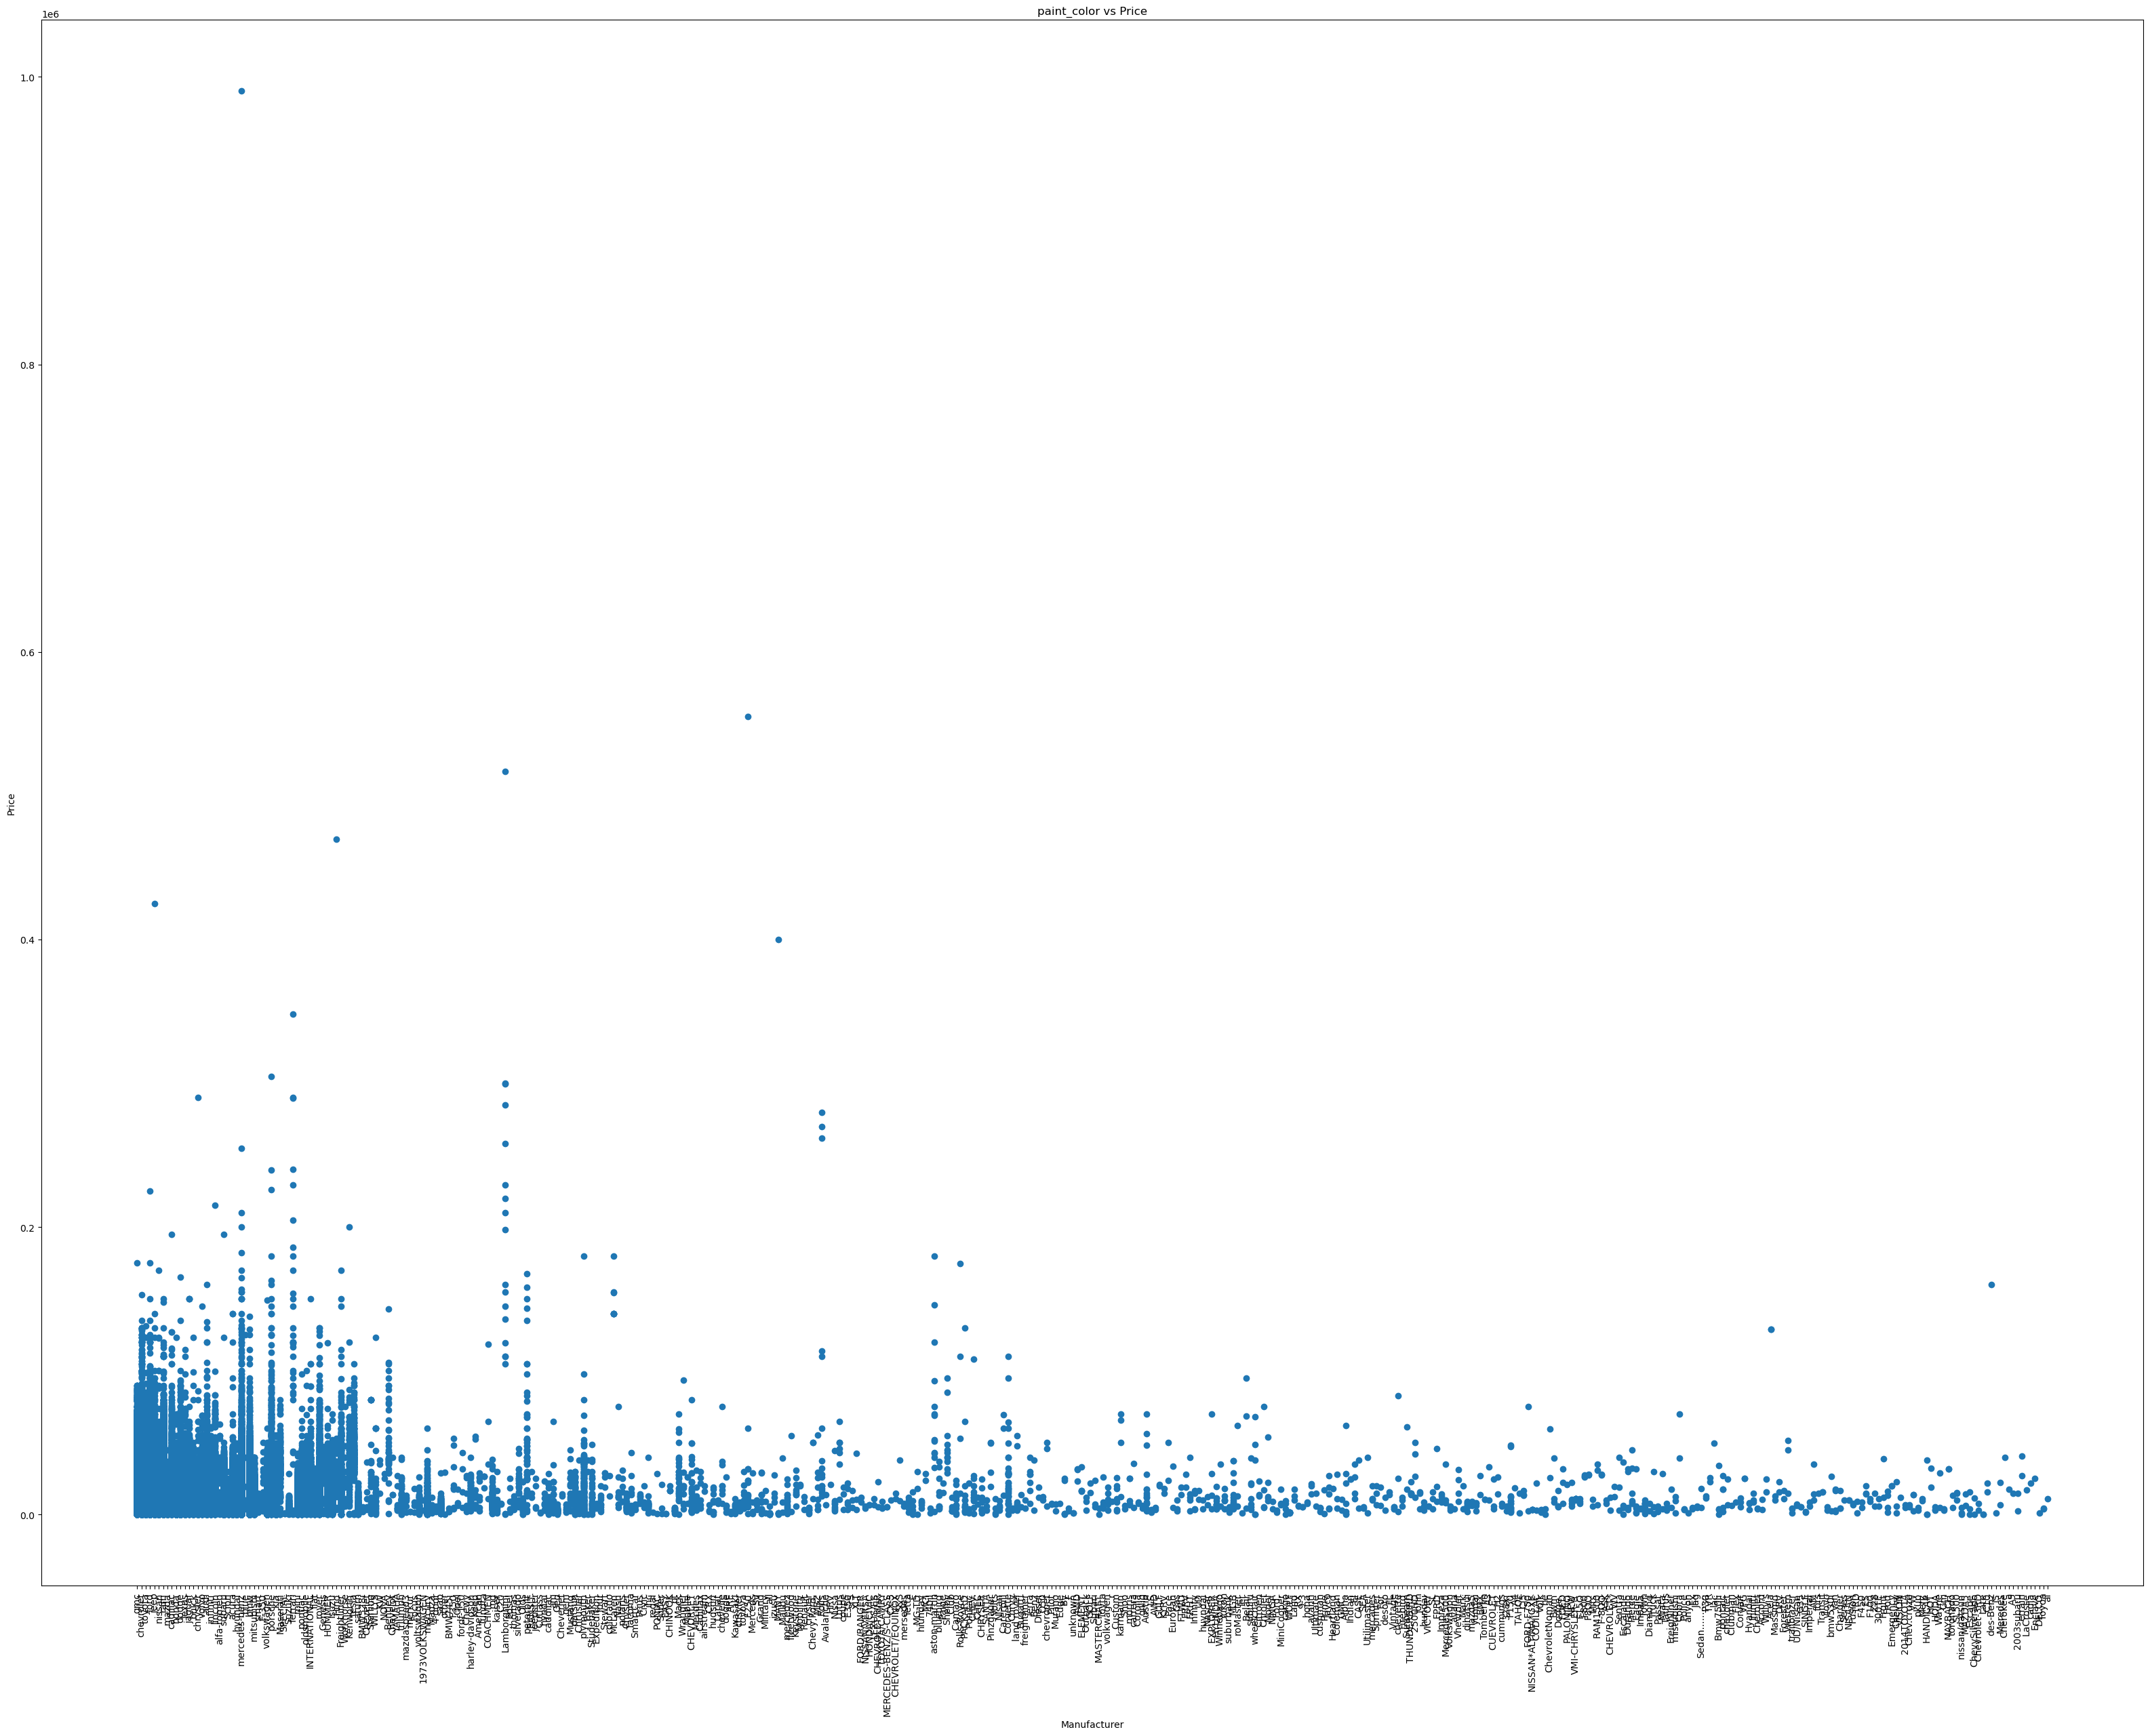

In [40]:
# Plot top 100 manufacturers by average peice

plt.figure(figsize=(40,30))
plt.scatter(x=data_final['manufacturer'], y=data_final['price'])
plt.title(feature+' vs Price')
plt.ylabel('Price')
plt.xlabel('Manufacturer')
plt.tick_params("x", rotation=90) 
plt.show()

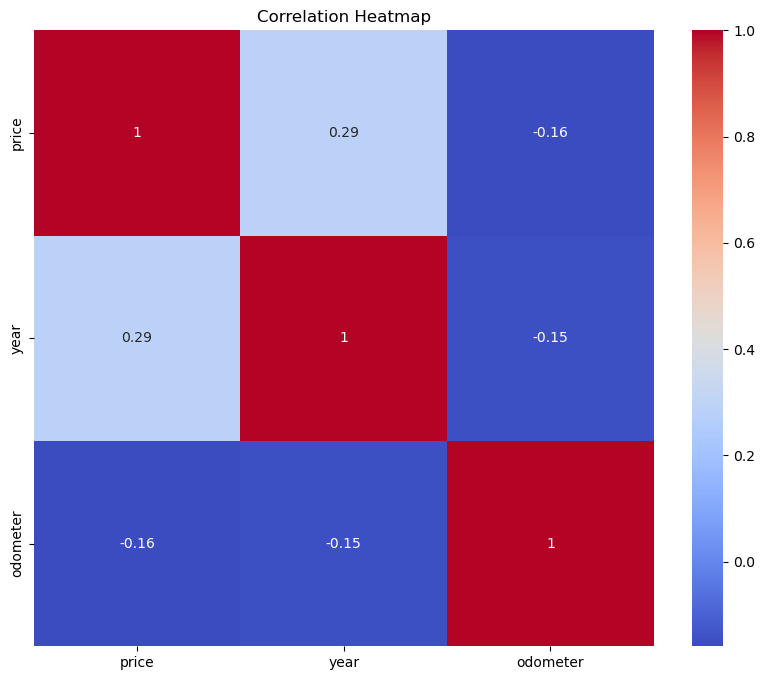

<class 'pandas.core.frame.DataFrame'>
Index: 184048 entries, 27 to 426838
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        184048 non-null  object 
 1   price         184048 non-null  int64  
 2   year          184048 non-null  float64
 3   manufacturer  184048 non-null  string 
 4   model         184048 non-null  string 
 5   condition     184048 non-null  object 
 6   cylinders     184048 non-null  object 
 7   fuel          184048 non-null  object 
 8   odometer      184048 non-null  float64
 9   title_status  184048 non-null  object 
 10  transmission  184048 non-null  object 
 11  VIN           184048 non-null  string 
 12  drive         184048 non-null  object 
 13  type          184048 non-null  object 
 14  paint_color   184048 non-null  object 
 15  state         184048 non-null  object 
dtypes: float64(2), int64(1), object(10), string(3)
memory usage: 23.9+ MB
None


Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Numerical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['year', 'odometer']),
                                                 ('Categorical_features',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'type',
                                                   'paint_color'])])),
                ('linReg', LinearRegression())])

In [42]:
# Correlation Analysis

numerical_features = ['price', 'year', 'odometer']

correlation_matrix = data_final[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

print(data_final.info())

categorical_columns_all = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'VIN', 'type', 'paint_color', 'state']

# Categorical columns of interest
categorical_columns = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'type', 'paint_color']

# # One-hot encode categorical variables
# df_encoded = pd.get_dummies(data_final[categorical_columns], categorical_columns)

# # Calculate the correlation matrix
# correlation_matrix = df_encoded.corr()

numerical_features_no_price = ['year', 'odometer']

preprocessor = ColumnTransformer(
    transformers=[
        ('Numerical_features', make_pipeline(SimpleImputer(),PolynomialFeatures(degree=3, include_bias=False)), numerical_features_no_price),
        ('Categorical_features', make_pipeline(OneHotEncoder(handle_unknown='ignore')), categorical_columns)
    ])

# Create a pipeline
pipeline = Pipeline([('Preprocessor', preprocessor), ('linReg', LinearRegression())
])
pipeline

In [44]:
# Test train split 
X = data_final.drop('price', axis=1)
y = data_final['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 22)

print(X_train.shape)
print(X_test.shape)
print(type(X_train), type(y_train))


(128833, 15)
(55215, 15)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [47]:
# Baseline MSE for Test and Train data

baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_train)
mse_baseline_test = mean_squared_error(baseline_test, y_test)

print(baseline_train.shape, baseline_test.shape)
print(f'Baseline for training data: {mse_baseline_train}')
print(f'Baseline for testing data: {mse_baseline_test}')

(128833,) (55215,)
Baseline for training data: 208808687.42799175
Baseline for testing data: 211380743.78703356


In [49]:
# Model Training features
pipeline.fit(X_train, y_train)

train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
### END SOLUTION

# Answer check
print(f'Train MSE: {train_mse: .2f}')
print(f'Test MSE: {test_mse: .2f}')

Train MSE:  208770022.02
Test MSE:  211351517.91


In [54]:
# Explore Ridge model
# Create a pipeline
pipeline2 = Pipeline([('Preprocessor', preprocessor), 
                      ('ridge', Ridge())])

pipeline2.fit(X_train, y_train)

train_preds_ridge = pipeline2.predict(X_train)
test_preds_ridge = pipeline2.predict(X_test)
train_mse_ridge = mean_squared_error(y_train, train_preds_ridge)
test_mse_ridge = mean_squared_error(y_test, test_preds_ridge)
### END SOLUTION

# Answer check
print(f'Train MSE - Ridge : {train_mse_ridge: .2f}')
print(f'Test MSE - Ridge : {test_mse_ridge: .2f}')

Train MSE - Ridge :  208770022.02
Test MSE - Ridge :  211351517.91


In [56]:
# Explore Lasso model
# Create a pipeline
pipeline3 = Pipeline([('Preprocessor', preprocessor), 
                      ('Lasso', Lasso(random_state = 42))])

pipeline3.fit(X_train, y_train)

train_preds_lasso = pipeline2.predict(X_train)
test_preds_lasso = pipeline2.predict(X_test)
train_mse_lasso = mean_squared_error(y_train, train_preds_lasso)
test_mse_lasso = mean_squared_error(y_test, test_preds_lasso)
### END SOLUTION

# Answer check
print(f'Train MSE - Lasso : {train_mse_lasso: .2f}')
print(f'Test MSE - Lasso : {test_mse_lasso: .2f}')

Train MSE - Lasso :  208770022.02
Test MSE - Lasso :  211351517.91
